In [1]:
import yfinance as yf
import pandas as pd
import numpy as np, random, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

etf_pairs = [('VO','IWB'), 
         ('VO','SPY'), 
         ('VO','SCHX'), 
         ('VO','SPLG'), 
         ('VO', 'IVV'),
         ('VO', 'VOO'), 
         ('DVY','IWR'), 
         ('SCHV', 'SPHQ'), 
         ('IWR','DIA'), 
         ('DVY','OEF'), 
         ('VTV', 'SPHQ'), 
         ('RSP', 'DIA'), 
         ('VO', 'DIA'), 
         ('DVY', 'FVD'), 
         ('DVY','VYM')] # closing

training_data = pd.read_csv("etf_train_prices.csv", index_col = 0, parse_dates = True)
testing_data = pd.read_csv("etf_test_prices.csv", index_col = 0, parse_dates = True)

In [2]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def rolling_zscore(series, window = 60):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

def predict_mean_reversion_label(
    spread,
    z_window = 60,
    horizon = 10,
    entry_z = 1.0,
    min_pnl = 0.0,
):

    z = rolling_zscore(spread, window=z_window)

    direction = -np.sign(z)

    future_spread = spread.shift(-horizon)

    spread_change = future_spread - spread
    pnl = direction * spread_change

    cond_entry = z.abs() >= entry_z

    labels = ((cond_entry) & (pnl > min_pnl)).astype(float)

    labels = labels.iloc[:-horizon]

    labels = labels.dropna()

    return labels


def create_features(spread, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = rolling_zscore(df['spread'])
    
    df['z-score_lag1'] = df['z-score'].shift(1)
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag3'] = df['z-score'].shift(3)
    df['z-score_lag4'] = df['z-score'].shift(4)
    df['z-score_lag5'] = df['z-score'].shift(5)
    df['spread_lag1'] = df['spread'].shift(1)
    df['spread_lag2'] = df['spread'].shift(2)
    df['spread_lag3'] = df['spread'].shift(3)
    df['spread_lag4'] = df['spread'].shift(4)
    df['spread_lag5'] = df['spread'].shift(5)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    
    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

for etf1, etf2 in etf_pairs:

    pair_name = f'{etf1}_{etf2}'

    window = 5

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, window = window)
    test_features = create_features(testing_spread, window = window)

    train_labels = predict_mean_reversion_label(
            training_spread,
            z_window = 60,
            horizon = 5,
            entry_z = 1.0,
            min_pnl = 0.0,
        )

    test_labels = predict_mean_reversion_label(
            testing_spread,
            z_window = 60,
            horizon = 5,
            entry_z = 1.0,
            min_pnl = 0.0,
        )

    train_idx = train_features.index.intersection(train_labels.index)
    test_idx  = test_features.index.intersection(test_labels.index)

    train_features = train_features.loc[train_idx].copy()
    test_features  = test_features.loc[test_idx].copy()

    train_labels = train_labels.loc[train_idx]
    test_labels  = test_labels.loc[test_idx]

    train_features['label'] = train_labels
    test_features['label']  = test_labels

    train_features = train_features.dropna(subset=['label'])
    test_features  = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name]  = test_features.drop(columns=['label'])
    y_test_dict[pair_name]  = test_features['label']

training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

In [3]:
param_grid = {
    'n_neighbors': [3, 5, 7, 11, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

best_params_dict = {}
best_scores_dict = {}
knn_models = {}
scalers = {}
test_reports = {}

cv = TimeSeriesSplit(n_splits = 5)

for pair_name in X_train_dict.keys():
    print(f"\nGrid search KNN for {pair_name}")
    
    X_train, y_train = X_train_dict[pair_name], y_train_dict[pair_name]
    X_test, y_test = X_test_dict[pair_name], y_test_dict[pair_name]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers[pair_name] = scaler
    
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_params_dict[pair_name] = grid_search.best_params_
    best_scores_dict[pair_name] = grid_search.best_score_
    
    best_knn = grid_search.best_estimator_
    knn_models[pair_name] = best_knn
    y_pred = best_knn.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    test_reports[pair_name] = {
        'accuracy': acc,
        'report': report
    }

    print(best_params_dict[pair_name])

print("\nGrid Search Completed for All Pairs")


Grid search KNN for VO_IWB
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Test Accuracy: 0.7045
              precision    recall  f1-score   support

         0.0       0.84      0.74      0.79       880
         1.0       0.45      0.60      0.51       308

    accuracy                           0.70      1188
   macro avg       0.64      0.67      0.65      1188
weighted avg       0.74      0.70      0.72      1188

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Grid search KNN for VO_SPY
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Test Accuracy: 0.5168
              precision    recall  f1-score   support

         0.0       0.82      0.44      0.57       877
         1.0       0.32      0.73      0.44       311

    accuracy                           0.52      1188
   macro avg       0.57      0.59      0.51      1188
weighted avg       0.69      0.52      0.54      1188

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'dis

In [4]:
results = {}

for pair_name in X_train_dict.keys():

    knn_model = knn_models[pair_name]
    scaler = scalers[pair_name]

    X_test_scaled = scaler.transform(X_test_dict[pair_name])
    y_test = y_test_dict[pair_name]

    probs = knn_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_label = knn_model.predict(X_test_scaled)

    results[pair_name] = {
        'model': knn_model,
        'y_true': y_test.values,
        'y_pred': probs
    }

In [5]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        price_df = testing_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [6]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [7]:
def simulate_portfolio(
    X_df, y_pred_label, prices_df,
    initial_cash_per_pair = 100.0,
    holding_period = 15,
    entry_threshold = 1,
):

    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['label'] = y_pred_label
    df['probs'] = probs

    probs_threshold = np.quantile(probs, 0.8)

    df = df.join(prices_df)

    cash = initial_cash_per_pair
    equity = pd.Series(index=df.index, dtype=float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        label = row['label']
        prob = row['probs']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (prob >= probs_threshold and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace=True)
    return equity, trades

In [8]:
def run_simulation(results, X_test_dict, testing_data, initial_cash_per_pair=100.0):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    sns.set_theme(style = "whitegrid", context = "notebook")

    plt.figure(figsize = (12, 6))
    plt.xlabel("Date", fontsize = 12)
    plt.ylabel("Portfolio Value ($)", fontsize = 12)
    plt.grid(True)
    plt.tight_layout()

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred_label = model_info['y_pred']

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(
            X_test_df,
            y_pred_label,
            prices_df,
            initial_cash_per_pair=initial_cash_per_pair
        )

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()
        sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252) if pair_returns.std() != 0 else np.nan
        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x = equity.index, y = equity.values, label = pair_name)

    plt.legend(title = "Pair", frameon = True, loc = "center left", bbox_to_anchor = (0, 0.64))
    plt.show()

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    total_sharpe = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {total_sharpe:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))  # last 10 rows
        print("-" * 40)

    cumulative_equity = combined_equity['Total']
    cumulative_equity.to_csv("equity_curves/knn_equity.csv", header = ["Portfolio Value"])

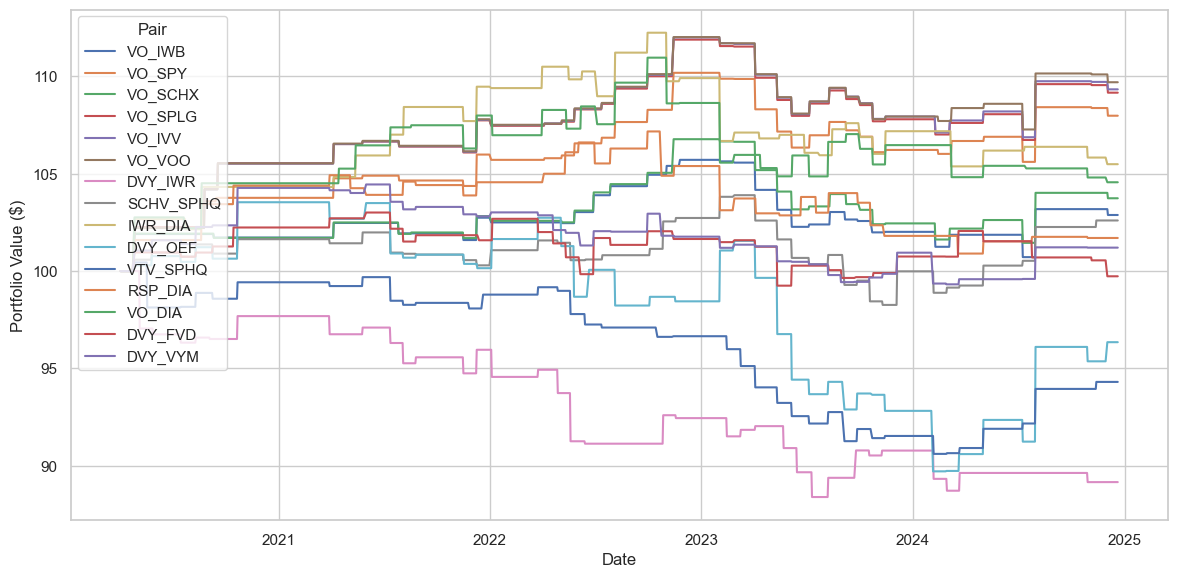


Final Portfolio Value: $1,537.89

Trade Summary:
  VO_IWB: 30 trades | Total PnL: $2.88 | Avg PnL: $0.10
  VO_SPY: 34 trades | Total PnL: $7.98 | Avg PnL: $0.23
  VO_SCHX: 31 trades | Total PnL: $3.74 | Avg PnL: $0.12
  VO_SPLG: 34 trades | Total PnL: $9.16 | Avg PnL: $0.27
  VO_IVV: 34 trades | Total PnL: $9.33 | Avg PnL: $0.27
  VO_VOO: 34 trades | Total PnL: $9.70 | Avg PnL: $0.29
  DVY_IWR: 35 trades | Total PnL: $-10.84 | Avg PnL: $-0.31
  SCHV_SPHQ: 41 trades | Total PnL: $2.60 | Avg PnL: $0.06
  IWR_DIA: 34 trades | Total PnL: $5.49 | Avg PnL: $0.16
  DVY_OEF: 40 trades | Total PnL: $-3.65 | Avg PnL: $-0.09
  VTV_SPHQ: 38 trades | Total PnL: $-5.69 | Avg PnL: $-0.15
  RSP_DIA: 32 trades | Total PnL: $1.70 | Avg PnL: $0.05
  VO_DIA: 34 trades | Total PnL: $4.56 | Avg PnL: $0.13
  DVY_FVD: 36 trades | Total PnL: $-0.27 | Avg PnL: $-0.01
  DVY_VYM: 42 trades | Total PnL: $1.20 | Avg PnL: $0.03

Year-End Portfolio Values:
                VO_IWB      VO_SPY     VO_SCHX     VO_SPLG  

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_12108/3222700301.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')


Exception ignored in: <function ResourceTracker.__del__ at 0x1098f5a80>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110fe1a80>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/anaconda3/envs/rise-project/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child proces

In [ ]:
run_simulation(results, X_test_dict, testing_data)